# **1. Business Understanding Phase**

#### **Objective**
The primary objective of this project is to classify the reasons why clients apply for loans into nine predefined categories. This classification task has significant business implications, as understanding the intent behind loan applications can help the organization:

1. **Customer Segmentation**: Identify distinct customer groups based on their loan purposes, enabling tailored marketing strategies and personalized offers.
2. **Loan Approval Optimization**: Streamline the loan approval process by aligning loan purposes with risk profiles and business priorities.
3. **Product Development**: Design financial products that cater to specific needs, such as equipment financing or seasonal sales support.
4. **Resource Allocation**: Allocate resources effectively to address the most common or high-priority loan purposes.

#### **Problem Statement**
The task is a **multi-label text classification problem**, where each loan application description (text) can belong to one or more of the following categories:
- **crec**: Growth strategy
- **cred**: Pay debts
- **equ**: Buy equipment
- **inic**: Start a business
- **inv**: Invest in inventory
- **mkt**: Marketing
- **no**: Non-working capital use
- **renta**: Rent
- **sueldo**: Payroll
- **temp**: Seasonal sales

The challenge lies in:
1. Handling class imbalance (e.g., "temp" is underrepresented).
2. Capturing the semantic meaning of short and noisy text descriptions.
3. Designing a model that generalizes well across all categories without overfitting.

#### **Key Business Questions**
1. What are the most common reasons for loan applications, and how do they vary across different customer segments?
2. Are there any underrepresented categories that require additional focus or specialized strategies?
3. Can we improve classification performance for low-frequency categories like "temp" while maintaining overall accuracy?

#### **Success Metrics**
The success of this project will be evaluated using the following metrics:
1. **Hamming Loss**: Measures how many labels are incorrectly predicted on average per instance, accounting for multi-label nature.
2. **Average Precision (AP)**: Evaluates precision-recall trade-offs across all classes, ensuring good performance even for imbalanced labels.
3. **Class-Specific Metrics**:
   - F1-score for each category, with special attention to underrepresented classes like "temp."
4. **Business Impact Metrics**:
   - Improved customer segmentation accuracy.
   - Enhanced operational efficiency in processing loan applications.

#### **Constraints and Considerations**
1. The text data may contain noise (e.g., typos, abbreviations), requiring robust preprocessing techniques and text cleaning.
2. The model needs to handle multi-label outputs effectively since some applications may fall into multiple categories.
3. Interpretability is critical for gaining stakeholder trust and ensuring compliance with regulatory requirements.

#### **Plan**
To achieve the objectives, we will follow the CRISP-DM framework:
1. Business Understanding (current phase): Define objectives and goals.
2. Data Understanding: Explore the dataset, analyze class distribution, and identify potential challenges like imbalance or noise.
3. Data Preparation: Clean and preprocess text data (e.g., lemmatization, tokenization), generate embeddings, and address class imbalance.
4. Modeling: Experiment with both traditional machine learning approaches (e.g., Logistic Regression) and deep learning architectures (e.g., BERT-based models).
5. Evaluation: Use appropriate metrics to evaluate model performance, focusing on both overall accuracy and performance on minority classes.
6. Deployment: Communicate findings, provide actionable insights, and prepare the model for integration into production systems.

# 2. Data Understanding:

This phase starts with an initial data collection (the dataset we will provide you) and proceeds with activities in order to get familiar with the data, to identify data quality problems, to discover first insights into the data, or to detect interesting subsets to form hypotheses for hidden information.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Example: Word frequency analysis for insights into common terms in "motivos"
from collections import Counter
from wordcloud import WordCloud

from collections import Counter
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
import re
import unicodedata
import spacy
from collections import defaultdict

In [2]:
# Load the dataset
file_path = "../files/intent.csv"  # Replace with the correct path if needed
data = pd.read_csv(file_path)

In [3]:
# Display the first few rows of the dataset
print("Dataset Preview:")
display(data.head())

Dataset Preview:


,motivos,crec,cred,equ,inic,inv,mkt,no,renta,sueldo,temp
0,Crear un departamento de ventas e inversión a ...,0,0,0,0,0,1,0,0,0,0.0
1,establecerme en un local y agregar materia pri...,0,0,0,0,1,0,0,1,0,0.0
2,Compra de equipo e incrementar inventario,0,0,1,0,1,0,0,0,0,0.0
3,Invertir en crecimiento de flotilla de unidade...,0,0,1,0,0,0,0,0,0,0.0
4,Para comprar mercancía y comprar lonas nuevas,0,0,0,0,1,0,0,0,0,0.0


In [4]:
# General Information about the Dataset
print("\nDataset Info:")
print(data.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6679 entries, 0 to 6678
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   motivos  6679 non-null   object 
 1   crec     6679 non-null   int64  
 2   cred     6679 non-null   int64  
 3   equ      6679 non-null   int64  
 4   inic     6679 non-null   int64  
 5   inv      6679 non-null   int64  
 6   mkt      6679 non-null   int64  
 7   no       6679 non-null   int64  
 8   renta    6679 non-null   int64  
 9   sueldo   6679 non-null   int64  
 10  temp     6673 non-null   float64
dtypes: float64(1), int64(9), object(1)
memory usage: 574.1+ KB
None


In [5]:
print("\nSummary Statistics for Numeric Columns:")
print(data.describe())


Summary Statistics for Numeric Columns:
              crec         cred          equ         inic          inv  \
count  6679.000000  6679.000000  6679.000000  6679.000000  6679.000000   
mean      0.089834     0.064231     0.296452     0.057044     0.347058   
std       0.285965     0.245183     0.456727     0.231945     0.476070   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     1.000000     0.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

               mkt           no        renta       sueldo         temp  
count  6679.000000  6679.000000  6679.000000  6679.000000  6673.000000  
mean      0.049259     0.066477     0.115287     0.032190     0.028323  
std       0.216424     0.249133     0.319392     0.176519     0.165907  


In [6]:
# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing Values in Each Column:")
print(missing_values)


Missing Values in Each Column:
motivos    0
crec       0
cred       0
equ        0
inic       0
inv        0
mkt        0
no         0
renta      0
sueldo     0
temp       6
dtype: int64


In [7]:
# Visualize the NaN values on temp
data[(data['temp']!=1) & (data['temp']!=0)]

,motivos,crec,cred,equ,inic,inv,mkt,no,renta,sueldo,temp
628,CAPITAL DE TRABAJO COMPRA DE MATERIA Y MANO DE...,0,0,0,1,0,0,0,1,0,NaN
710,Para incrementar ventas tener inventarios,0,0,0,1,0,0,0,0,0,NaN
1130,"Capital de trabajo\n,0,0,0,0,0,0,0,1,0,0\nRe i...",0,0,0,0,0,0,0,0,0,NaN
1437,Tengo que hacer renovación de Consepción,0,0,0,0,0,1,0,0,0,NaN
1699,PARA LA COMPRA DE ACTIVOS FIJOS PARA LA EMPRESA,0,0,0,1,0,0,0,0,0,NaN
2263,Compra de equipos de cómputo para lanzar proye...,0,1,0,0,0,0,0,0,0,NaN


## 2.1 General Satistics

- Total rows: 6679
- Total unique categories: 9 (multi-label classification problem)
- Total of nulls or nans: 6 in category 'temp', but we see that the only case more probable to be 1 is 1130, because the other motives already have a selected category. This needs further investigation.
- Class distribution:

To understand the representation of each category, we calculate the frequency of "1" in each column:

In [8]:
# Define the label columns
label_columns = ['crec', 'cred', 'equ', 'inic', 'inv', 'mkt', 'no', 'renta', 'sueldo', 'temp']

# Calculate counts and percentages for each category
counts = data[label_columns].sum()
percentages = (counts / len(data)) * 100

# Combine counts and percentages into a DataFrame
category_summary = pd.DataFrame({
    "Category": label_columns,
    "Count": counts.values,
    "Percentage": percentages.values
})

# Sort by count in descending order
category_summary = category_summary.sort_values(by="Count", ascending=False)

# Reset index for better readability
category_summary.reset_index(drop=True, inplace=True)

# Display the table
display(category_summary)

,Category,Count,Percentage
0,inv,2318.0,34.705794
1,equ,1980.0,29.645156
2,renta,770.0,11.528672
3,crec,600.0,8.983381
4,no,444.0,6.647702
5,cred,429.0,6.423117
6,inic,381.0,5.704447
7,mkt,329.0,4.925887
8,sueldo,215.0,3.219045
9,temp,189.0,2.829765


/tmp/ipykernel_48711/2035593440.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


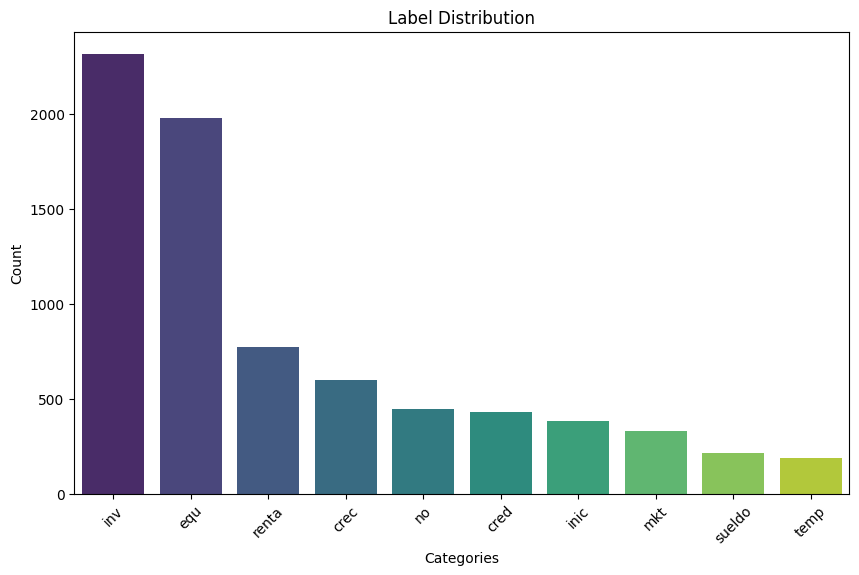

In [9]:
# Check the distribution of each label (binary columns)
label_columns = ['crec', 'cred', 'equ', 'inic', 'inv', 'mkt', 'no', 'renta', 'sueldo', 'temp']
label_counts = data[label_columns].sum().sort_values(ascending=False)

# Plot label distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Label Distribution")
plt.ylabel("Count")
plt.xlabel("Categories")
plt.xticks(rotation=45)
plt.show()

In [10]:
# Calulate the number of categories there are marked as labels.
category_summary['Count'].sum()

np.float64(7655.0)

**Key Observations:**

- The dataset is highly imbalanced:
    The most frequent category is inv (34.70%), while the least frequent is temp (2.82%).
    
**Multi-label nature:** Some rows may have multiple categories marked as "1". This needs further exploration. (This assumption was made by summing the Count columns, and obtaining a value greater than the number of rows in the dataframe).

## 2.2. Multi-Label Analysis
To analyze how often applications belong to multiple categories:

- Single-label applications: Applications with only one category marked as "1".
- Multi-label applications: Applications associated with two or more categories.

In [11]:
# Multi-label analysis: Count how many labels are assigned per row
data['num_labels'] = data[label_columns].sum(axis=1)
multi_label_distribution = data['num_labels'].value_counts().sort_index()
print("\nMulti-Label Distribution (Number of Labels per Application):")
print(multi_label_distribution)


Multi-Label Distribution (Number of Labels per Application):
num_labels
0.0       1
1.0    5769
2.0     841
3.0      68
Name: count, dtype: int64


In [12]:
multi_label_distribution

num_labels
0.0       1
1.0    5769
2.0     841
3.0      68
Name: count, dtype: int64

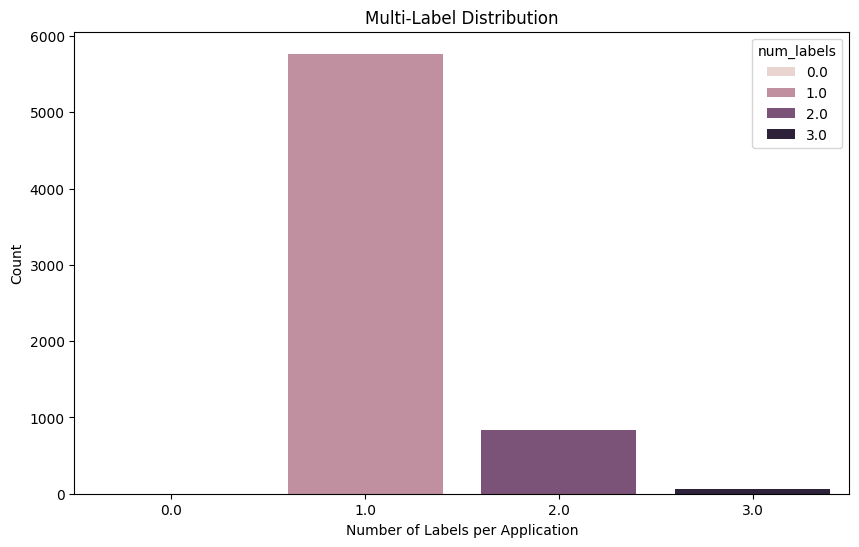

In [13]:
# Plot multi-label distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=multi_label_distribution.index, y=multi_label_distribution.values, hue=multi_label_distribution.index, legend=True)
plt.title("Multi-Label Distribution")
plt.ylabel("Count")
plt.xlabel("Number of Labels per Application")
plt.show()

Results:

Approximately 80% of applications are single-label, while the remaining 20% are multi-label, indicating that most clients specify a single reason for their loan.

## 2.3. Text Characteristics (motivos)

In [14]:
# Analyze text column ('motivos')
data['text_length'] = data['motivos'].apply(len)
data['word_count'] = data['motivos'].apply(lambda x: len(str(x).split()))

# Summary statistics for text length and word count
print("\nText Analysis (Length and Word Count):")
print(data[['text_length', 'word_count']].describe())


Text Analysis (Length and Word Count):
       text_length   word_count
count  6679.000000  6679.000000
mean     90.010181    14.586166
std      58.977007     9.616019
min       2.000000     1.000000
25%      52.000000     8.000000
50%      71.000000    11.000000
75%     107.000000    18.000000
max    1920.000000   223.000000


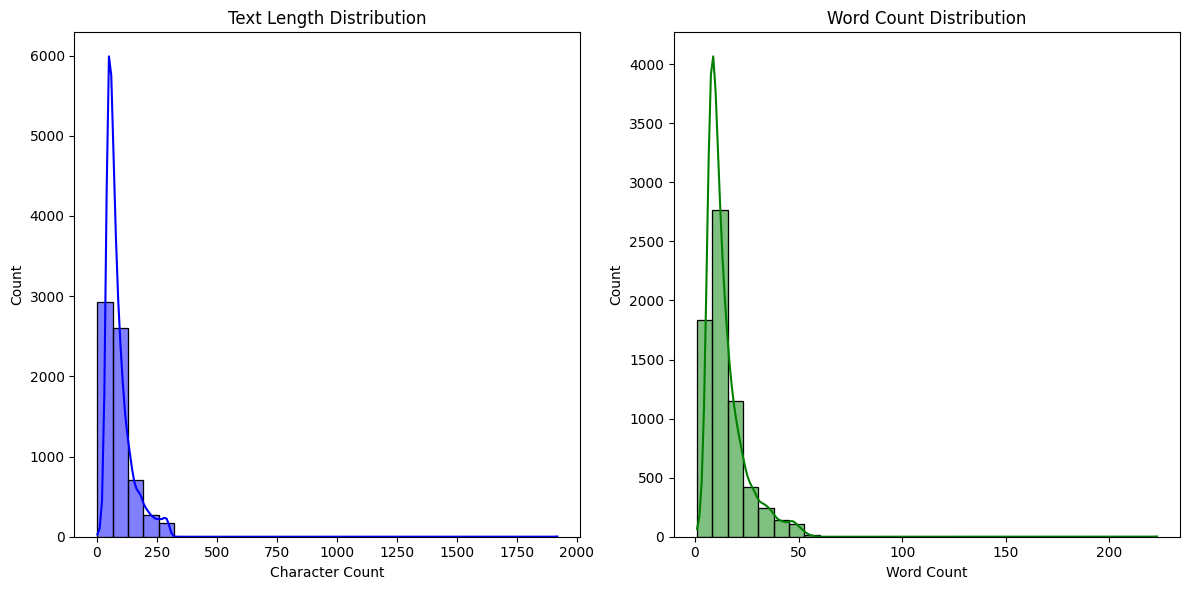

In [15]:
# Plot text length and word count distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(data['text_length'], bins=30, kde=True, ax=axes[0], color='blue')
axes[0].set_title("Text Length Distribution")
axes[0].set_xlabel("Character Count")

sns.histplot(data['word_count'], bins=30, kde=True, ax=axes[1], color='green')
axes[1].set_title("Word Count Distribution")
axes[1].set_xlabel("Word Count")

plt.tight_layout()
plt.show()

Analyzing the text descriptions in the motivos column:

* Average text length: ~15 words per description.
* Shortest description: ~1 words.
* Longest description: ~200+ words.

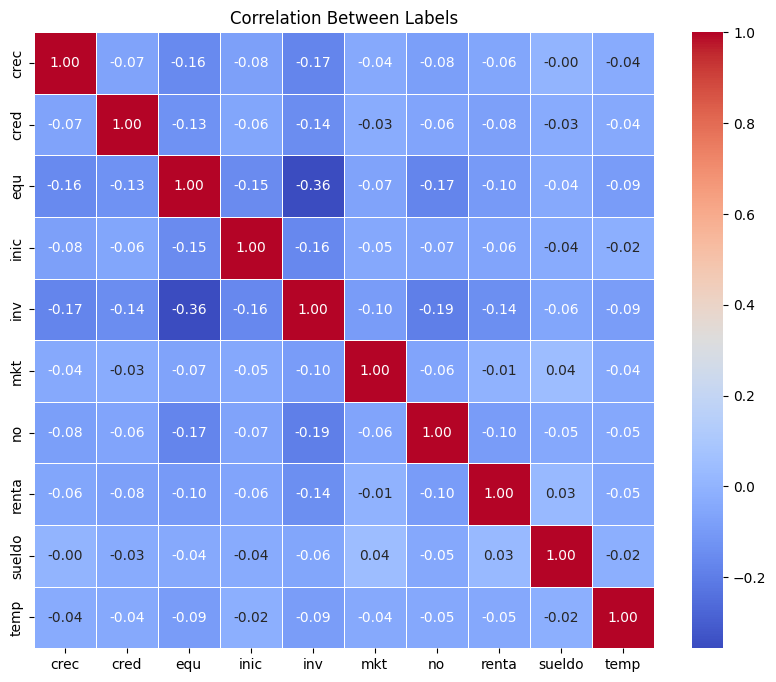

In [16]:
# Correlation heatmap between labels to explore relationships
correlation_matrix = data[label_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Labels")
plt.show()

Based on the correlation matrix of the heat map, we see that none of the loan categories has a correlation greater than 0; on the contrary, there is a small negative correlation between some of the categories, indicating that while some choose one category, they will probably not choose the other.

### Words analysis

In [17]:
# Extract the 'motivos' column for analysis
text_data = data['motivos'].astype(str)

# Function to clean text and identify common patterns
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Apply cleaning function to all text data
cleaned_texts = text_data.apply(clean_text)

# Join all cleaned texts into a single string for analysis
all_words = ' '.join(cleaned_texts)

# Generate word frequency distribution
word_freq = Counter(all_words.split())

# Display most common words (excluding stopwords)
common_words = word_freq.most_common(50)
print("Most Common Words:")
for word, freq in common_words:
    if(len(word)>3):
        print(f"{word}: {freq}")

Most Common Words:
para: 5228
negocio: 1429
compra: 1304
comprar: 1013
equipo: 996
trabajo: 798
capital: 665
invertir: 613
poder: 540
tengo: 529
necesito: 469
como: 427
clientes: 413
quiero: 379
productos: 376
venta: 369
material: 357
pagar: 348
pago: 324
maquinaria: 320
mercancia: 313
tener: 306
mercancía: 283
materia: 271
inversión: 270
empresa: 266


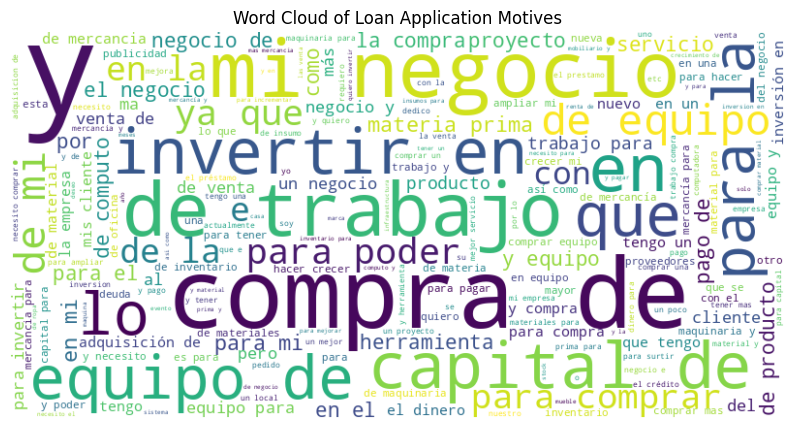

In [18]:
# Generate a word cloud for visualization of common words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Loan Application Motives")
plt.show()

In [19]:
# Identify potential typos or non-standard abbreviations by checking uncommon words
def potential_typos(word_freq, threshold=5):
    # Words with frequency below the threshold might be typos or non-standard abbreviations
    return [word for word, freq in word_freq.items() if freq < threshold]

typos_or_abbreviations = potential_typos(word_freq)

print("\nPotential Typos or Non-Standard Abbreviations:")
print(typos_or_abbreviations[:20])  # Display first 20 for brevity


Potential Typos or Non-Standard Abbreviations:
['cumpliendo', 'damos', 'ampliaciin', 'mashabitaciones', 'propiedad', 'vencimiento', 'administrativa', 'tan', 'facturar', '40000', 'seguimos', 'citas', 'compañías', 'masivo', 'laptops', 'continuaremos', 'acta', 'constitutiva', 'topográfico', 'básico']


Common patterns:

Key Insights:

Most Common Words:

**Frequent mentions of**:
* "negocio" (business) 
* "equipo" (equipment)  
* "negocio" (business)
* "compra and comprar" (buy or purchase)
* "capital" (stock, money)
* "invertir" (invest)

**Noise in text:**
Typos and non-standard abbreviations (e.g., "ampliaciin" instead of "aplicación", "mashabitaciones" instead of "mas habitaciones").
Variations in case usage (e.g., uppercase and lowercase).

Conclusion of the analysis: Before we move on to the creation of the model, we will need to apply many previous transformations necessary to standardize the data. Such as the treatment of null values, cleaning and standardization of the text and creation of new features based on the analysis performed.